# **Deep Neural Networks on Fashion MNIST**


## **Imports**

In [45]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import metrics
%matplotlib inline

# **Loading the Dataset**

In [16]:
train_dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

In [17]:
val_size = 10000
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [18]:
# Batch Size
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2)

# **Visualizing the Dataset**

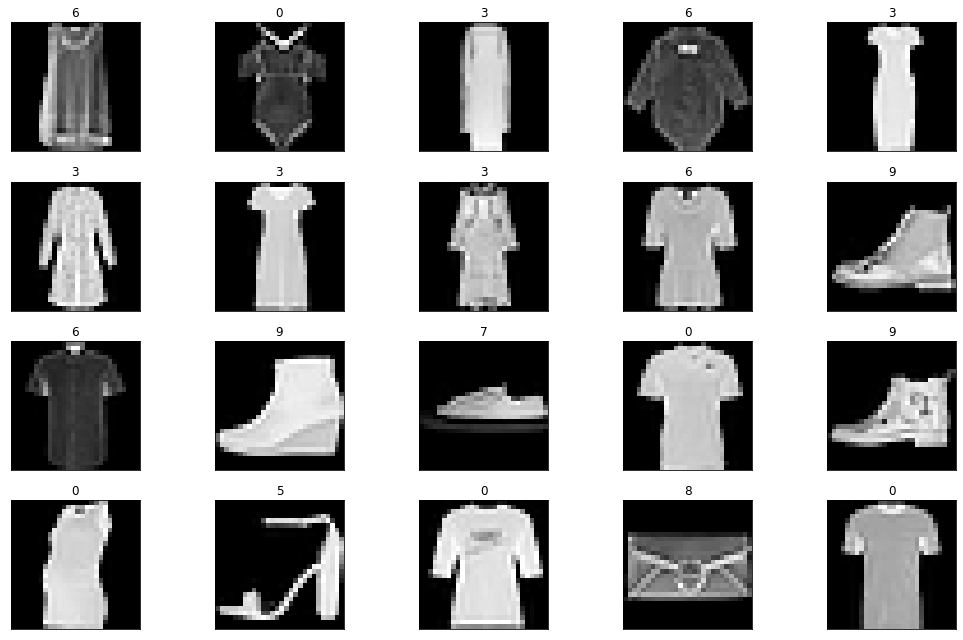

In [5]:
dataiter = iter(train_loader)
print(dataiter)
images, labels = dataiter.next()
fig = plt.figure(figsize=(16,9))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

# **Network Architecture**

In [82]:
class FasionMnistModel(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        out = self.layers(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        criterion = nn.NLLLoss()                  
        loss = criterion(out, labels) 
        return loss
    
    def validation(self, batch):
        images, labels = batch 
        out = self(images)                    
        criterion = nn.NLLLoss()                  
        loss = criterion(out, labels)    
        acc = accuracy(out, labels)           
        return {'validation_loss': loss, 'validation_accuracy': acc}
        
    def epoch_validation(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['validation_accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(epoch, result['validation_loss'], result['validation_accuracy']))

In [83]:
def accuracy(outputs, labels):
    n, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation(batch) for batch in val_loader]
    return model.epoch_validation(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    train_losses = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        training_loss = 0 
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            training_loss += loss.item()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        training_loss = training_loss/len(train_loader)
        train_losses.append(training_loss)
    return history, train_losses

In [84]:
model = FasionMnistModel()

In [85]:
# Before Training
history = [evaluate(model, val_loader)]
history

[{'validation_accuracy': 0.08642578125, 'validation_loss': 2.3066539764404297}]

**Training Model**

In [86]:
history, train_losses = fit(40, 0.002, model, train_loader, val_loader)

Epoch [0], validation_loss: 0.5114, validation_accuracy: 0.8125
Epoch [1], validation_loss: 0.4337, validation_accuracy: 0.8408
Epoch [2], validation_loss: 0.4108, validation_accuracy: 0.8587
Epoch [3], validation_loss: 0.3884, validation_accuracy: 0.8593
Epoch [4], validation_loss: 0.3856, validation_accuracy: 0.8592
Epoch [5], validation_loss: 0.3861, validation_accuracy: 0.8596
Epoch [6], validation_loss: 0.3761, validation_accuracy: 0.8694
Epoch [7], validation_loss: 0.3593, validation_accuracy: 0.8738
Epoch [8], validation_loss: 0.3643, validation_accuracy: 0.8706
Epoch [9], validation_loss: 0.3540, validation_accuracy: 0.8759
Epoch [10], validation_loss: 0.3732, validation_accuracy: 0.8663
Epoch [11], validation_loss: 0.3569, validation_accuracy: 0.8800
Epoch [12], validation_loss: 0.3553, validation_accuracy: 0.8754
Epoch [13], validation_loss: 0.3692, validation_accuracy: 0.8797
Epoch [14], validation_loss: 0.3636, validation_accuracy: 0.8740
Epoch [15], validation_loss: 0.3444

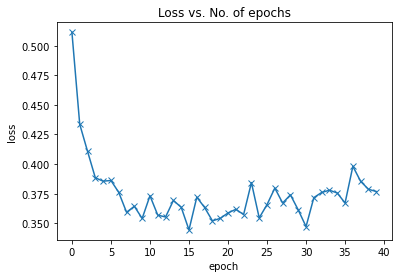

In [88]:
losses = [x['validation_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.title('Loss vs. No. of epochs');

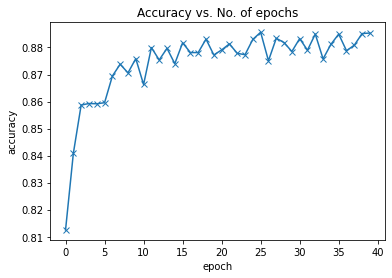

In [89]:
accuracies = [x['validation_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

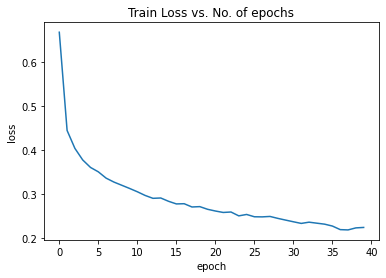

In [100]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train Loss vs. No. of epochs');

In [81]:
# After Training
history = [evaluate(model, val_loader)]
history

[{'validation_accuracy': 0.887988269329071,
  'validation_loss': 0.37094226479530334}]

# **Testing the Neural Network**

In [91]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [92]:
# Test set
with torch.no_grad():
    test_preds = get_all_preds(model, test_loader)

In [93]:
# Training set
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)

**Performance Measures**

**Test Dataset**

In [94]:
f1 = metrics.f1_score(test_dataset.targets, test_preds.argmax(dim=1), average= "weighted")
precision = metrics.precision_score(test_dataset.targets, test_preds.argmax(dim=1),average='macro')
recall = metrics.recall_score(test_dataset.targets, test_preds.argmax(dim=1),average='macro')
print("F1 Score:",f1)
print("Precision:",precision)
print("Recall:",recall)

F1 Score: 0.880200380710337
Precision: 0.8804981289712916
Recall: 0.8802


**Train Dataset**

In [95]:
f1 = metrics.f1_score(train_dataset.targets, train_preds.argmax(dim=1), average= "weighted")
precision = metrics.precision_score(train_dataset.targets, train_preds.argmax(dim=1),average='macro')
recall = metrics.recall_score(train_dataset.targets, train_preds.argmax(dim=1),average='macro')
print("F1 Score:",f1)
print("Precision:",precision)
print("Recall:",recall)

F1 Score: 0.9185405374396165
Precision: 0.9186590392492195
Recall: 0.9185000000000001


In [96]:
cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
cm

array([[831,   1,  12,  30,   4,   1, 116,   0,   5,   0],
       [  6, 965,   1,  21,   3,   0,   4,   0,   0,   0],
       [ 12,   3, 789,  12, 107,   0,  71,   0,   6,   0],
       [ 21,   5,  10, 890,  44,   0,  26,   0,   4,   0],
       [  0,   0,  93,  41, 795,   0,  69,   0,   2,   0],
       [  0,   0,   1,   1,   0, 965,   0,  23,   2,   8],
       [115,   0,  89,  32,  65,   1, 684,   0,  14,   0],
       [  0,   0,   0,   0,   0,   9,   0, 975,   0,  16],
       [  4,   0,   9,   5,   3,   1,   5,   4, 969,   0],
       [  0,   0,   0,   0,   0,  14,   1,  46,   0, 939]])

In [97]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Confusion Matrix**

[[831   1  12  30   4   1 116   0   5   0]
 [  6 965   1  21   3   0   4   0   0   0]
 [ 12   3 789  12 107   0  71   0   6   0]
 [ 21   5  10 890  44   0  26   0   4   0]
 [  0   0  93  41 795   0  69   0   2   0]
 [  0   0   1   1   0 965   0  23   2   8]
 [115   0  89  32  65   1 684   0  14   0]
 [  0   0   0   0   0   9   0 975   0  16]
 [  4   0   9   5   3   1   5   4 969   0]
 [  0   0   0   0   0  14   1  46   0 939]]


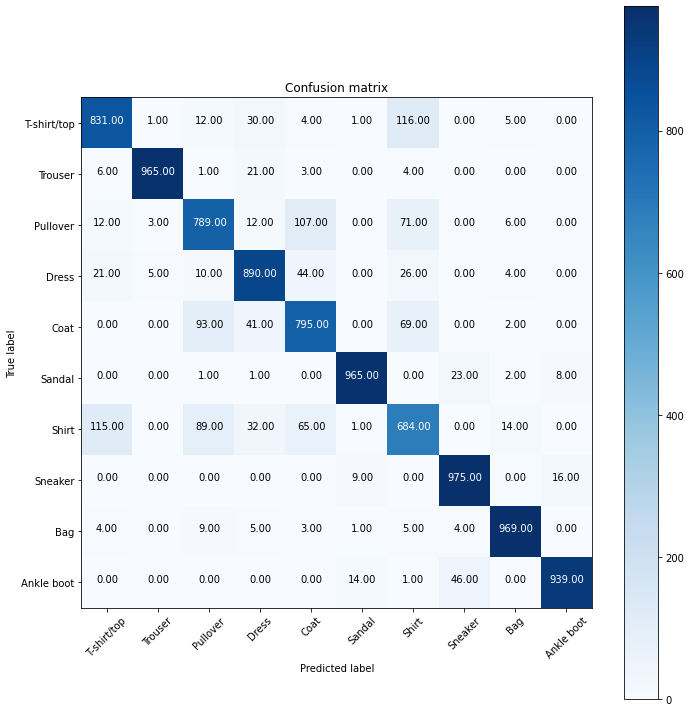

In [98]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, test_dataset.classes)

In [72]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


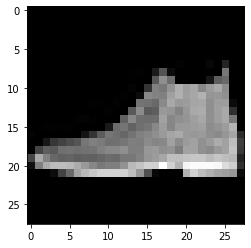

In [73]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', train_dataset.classes[label], ', Predicted:', train_dataset.classes[predict_image(img, model)])

**Predictions**

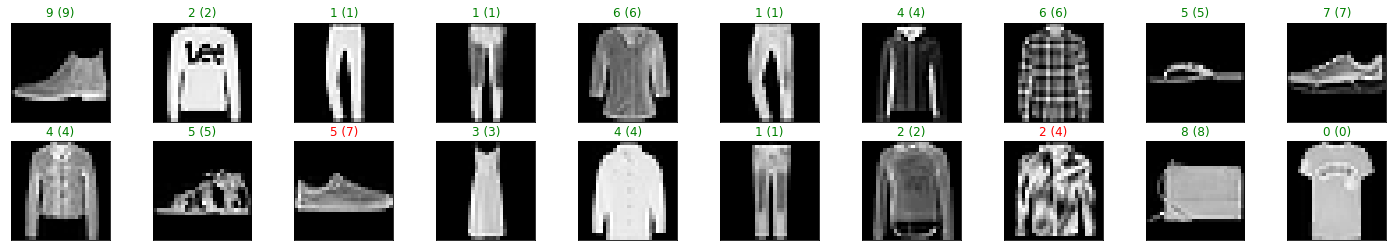

In [99]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [105]:
torch.save(model.state_dict(), 'D:\\model\\')